In [109]:
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import gensim
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix,hstack
from tqdm import tqdm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ProBook\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ProBook\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data = os.path.abspath(os.path.join('.','data', 'clean_data.csv'))

In [6]:
df = pd.read_csv(data)

In [7]:
df.head()

,Unnamed: 0,Content,Spam_or_Scam,clean_text
0,0,Walk I paper suddenly still stop.,0,walk paper suddenly still stop
1,1,Voice television free building house step lose...,0,voice television free building house step lose...
2,2,Movie fast cold reach field girl forward best ...,0,movie fast cold reach field girl forward good ...
3,3,Color themselves.,1,color themselves
4,4,Heavy recognize sea trip fill safe former ques...,0,heavy recognize sea trip fill safe former ques...


### Text Featurization

In [121]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from tqdm import tqdm
from gensim.models import Word2Vec

class TextFeaturization:
    def __init__(self):
        self.word2vec_model = None

    def train_word2vec(self, corpus):
        # Train your Word2Vec model on the corpus
        tokenized_corpus = [word_tokenize(doc.lower()) for doc in corpus]
        self.word2vec_model = Word2Vec(tokenized_corpus, vector_size=300, window=5, min_count=1, workers=4)

    def remove_stopwords(self, docs, stopword_list):
        '''This function removes the stop words'''
        clean_docs = []
        for doc in docs:
            if isinstance(doc, str):  # Check if it's a string
                word_list = word_tokenize(doc)
                cleaned_txt = [w for w in word_list if not w in stopword_list]
                cleaned_string = " ".join(cleaned_txt)
                clean_docs.append(cleaned_string)
            elif isinstance(doc, float) and pd.isna(doc):  # Check if it's NaN
                clean_docs.append("")  # Append an empty string for NaN values
        return clean_docs
  
    def word_count(self, docs):
        '''This function retuns an array of word count in each document'''
        doc_len = []
        for doc in docs:
            doc_len.append(len(doc.split()))
        return np.array(doc_len)

    def average_word_length(self, docs):
        '''This function returns an array of average word length in each document'''
        average_word_length = []
        for doc in docs:
            total_length = 0
            num_words = len(doc.split())
            if num_words != 0:  # Check if there are words in the document
                for word in doc.split():
                    total_length += len(word)
                average_word_length.append(total_length / num_words)
            else:
                average_word_length.append(0)  # Append 0 for empty documents
        return np.array(average_word_length)
    
    def bag_of_words(self, train_data):
        '''This function creates bag of word representation for train data'''
        vectorizer_bow = CountVectorizer()
        vectorizer_bow.fit(train_data)
        text_bow_train = vectorizer_bow.transform(train_data)
        return vectorizer_bow, text_bow_train

    def tfidf_weighted_word2vec_train(self, train_data):
        '''This function creates TFIDF weighted W2V representation of train data'''
        # Create TF-IDF model
        tfidf_model = TfidfVectorizer()
        tfidf_model.fit(train_data)
        idf_dictionary = dict(zip(tfidf_model.get_feature_names_out(), tfidf_model.idf_))
        tfidf_words = set(tfidf_model.get_feature_names_out())

        # Initialize word vectors
        tfidf_w2v_vectors_train = []

        # Iterate over each document in the training data
        for sentence in tqdm(train_data):
            vector = np.zeros(300)  # Initialize word vector for the document
            tf_idf_weight = 0  # Initialize total TF-IDF weight for the document

            # Iterate over each word in the document
            for word in sentence.split():
                if word in self.word2vec_model.wv and word in tfidf_words:
                    vec = self.word2vec_model.wv[word]  # Get word vector
                    tf_idf = idf_dictionary[word] * (sentence.count(word) / len(sentence.split()))  # Compute TF-IDF
                    vector += vec * tf_idf  # Add TF-IDF weighted word vector to document vector
                    tf_idf_weight += tf_idf  # Update total TF-IDF weight

            # Normalize the document vector by the total TF-IDF weight
            if tf_idf_weight != 0:
                vector /= tf_idf_weight

            # Append the TF-IDF weighted document vector to the list
            tfidf_w2v_vectors_train.append(vector)

        return tfidf_w2v_vectors_train, idf_dictionary, tfidf_words
    
    def tfidf_weighted_word2vec_test(self, test_data, idf_dictionary, tfidf_words):
        '''This function creates TFIDF representation of test data'''
        tfidf_w2v_vectors_test = []  # Initialize list to store TF-IDF weighted Word2Vec vectors for test data
        
        # Iterate over each sentence in the test data
        for sentence in tqdm(test_data):
            vector = np.zeros(300)  # Initialize vector for the sentence
            tf_idf_weight = 0  # Initialize total TF-IDF weight for the sentence
            
            # Iterate over each word in the sentence
            for word in sentence.split():
                if (word in self.word2vec_model.wv) and (word in tfidf_words):
                    vec = self.word2vec_model.wv[word]  # Get the Word2Vec vector for the word
                    tf_idf = idf_dictionary[word] * (sentence.count(word) / len(sentence.split()))  # Compute TF-IDF
                    vector += vec * tf_idf  # Add TF-IDF weighted Word2Vec vector to the sentence vector
                    tf_idf_weight += tf_idf  # Update total TF-IDF weight
            
            # Normalize the sentence vector by the total TF-IDF weight
            if tf_idf_weight != 0:
                vector /= tf_idf_weight
            
            # Append the TF-IDF weighted sentence vector to the list
            tfidf_w2v_vectors_test.append(vector)
        
        return tfidf_w2v_vectors_test

    def tfidf_train(self, train_data):
        '''This function creates TFIDF representation of train data'''
        vectorizer_tfidf = TfidfVectorizer(min_df=10)
        vectorizer_tfidf.fit(train_data)
        text_tfidf_train = vectorizer_tfidf.transform(train_data)
        return vectorizer_tfidf, text_tfidf_train
  
    def tfidf_test(self, tfidf_model, test_data):
        '''This function creates TFIDF representation of test data'''
        return tfidf_model.transform(test_data)

    def avg_word2vec(self, docs):
        avg_wv = []
        for doc in tqdm(docs):
            vector = np.zeros(300)
            num_words = 0
            for word in doc:
                if word in self.word2vec_model.wv:
                    vector += self.word2vec_model.wv[word]
                    num_words += 1
            if num_words != 0:
                vector /= num_words
            avg_wv.append(vector)
        return avg_wv

    def topic_modelling(self, train_data):
        '''This function performs lda topic modelling for 2 topics and create trains lda with train data'''
        vectorizer_bow, bow = self.bag_of_words(train_data)
        lda_model = LatentDirichletAllocation(n_components=2, learning_method='online', max_iter=20, random_state=100)
        lda_model.fit(bow)
        train_lda = lda_model.transform(bow)
        return lda_model, vectorizer_bow, train_lda

    def perform_lda(self, train_data, test_data):
        '''This function performs lda on test data'''
        lda_model, vectorizer_bow, train_lda = self.topic_modelling(train_data)
        bow = vectorizer_bow.transform(test_data)
        return lda_model.transform(bow)

    def featurize(self, X_train, X_test, text_stopwords):
        '''This function featurize text data as w2V,word length,avg word length,lda topic modelling for given train and test data'''
        train_doc = self.remove_stopwords(X_train, text_stopwords)
        test_doc = self.remove_stopwords(X_test, text_stopwords)

        word_count_train = self.word_count(train_doc).reshape(-1, 1)
        avg_word_len_train = self.average_word_length(train_doc).reshape(-1, 1)
        lda_train = np.array(self.topic_modelling(train_doc)[2])
        tfidf_model, tfidf_train_vec = self.tfidf_train(train_doc)
        avg_wv_train = self.avg_word2vec(train_doc)
        tfidf_w2v_vectors_train, idf_dictionary, tfidf_words = self.tfidf_weighted_word2vec_train(train_doc)
        tfidf_w2v_vectors_train = np.array(tfidf_w2v_vectors_train)
        email_train = np.hstack((word_count_train, avg_word_len_train, lda_train, tfidf_train_vec.todense(), avg_wv_train, tfidf_w2v_vectors_train))

        word_count_test = self.word_count(test_doc).reshape(-1, 1)
        avg_word_len_test = self.average_word_length(test_doc).reshape(-1, 1)
        lda_test = self.perform_lda(train_doc, test_doc)
        tfidf_test_vec = self.tfidf_test(tfidf_model, test_doc)
        avg_wv_train = self.avg_word2vec(test_doc)
        tfidf_w2v_vectors_test = np.array(self.tfidf_weighted_word2vec_test(test_doc, idf_dictionary, tfidf_words))
        email_test = np.hstack((word_count_test, avg_word_len_test, lda_test, tfidf_test_vec.todense(), avg_wv_train, tfidf_w2v_vectors_test))

        return email_train, email_test


In [122]:
tf = TextFeaturization()

In [123]:
df.head()

,Unnamed: 0,Content,Spam_or_Scam,clean_text
0,0,Walk I paper suddenly still stop.,0,walk paper suddenly still stop
1,1,Voice television free building house step lose...,0,voice television free building house step lose...
2,2,Movie fast cold reach field girl forward best ...,0,movie fast cold reach field girl forward good ...
3,3,Color themselves.,1,color themselves
4,4,Heavy recognize sea trip fill safe former ques...,0,heavy recognize sea trip fill safe former ques...


In [124]:
X = df['clean_text']
y = df['Spam_or_Scam']

In [125]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [126]:
df.dropna(inplace=True)

In [127]:
text_corpus =''
for txt in df['clean_text']:
    txt = txt.lower()
    text_corpus += txt

In [128]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations = False,
                min_font_size = 10,max_words=200).generate(text_corpus)
 

In [129]:
text_stopwords = set(dict(wordcloud.words_).keys()).union(set(stopwords.words('english')))

In [130]:
tf.train_word2vec(X_train)


In [131]:
train,test = tf.featurize(X_train,X_test,text_stopwords=text_stopwords)

100%|██████████| 1997/1997 [00:00<00:00, 12093.93it/s]


In [143]:
col = ["Word Count","Average Word length","Topic 1","Topic 2"]
col.extend(["tfidf_d"+str(i) for i in range(0,862)])#column name for pandas dataframe
col.extend(["avg_wv_d"+str(i) for i in range(0,200)])
col.extend(["tfidf_w2v_d"+str(i) for i in range(0,200)])
     

In [144]:
train.shape

(7988, 1266)

In [145]:
df_train = pd.DataFrame(train,columns=col)

In [146]:
y_train = y_train.reset_index()#resetting index of y_train
y_train.drop(['index'],axis=1)
     

,Spam_or_Scam
0,0
1,0
2,0
3,1
4,0
...,...
7983,0
7984,1
7985,0
7986,0


In [147]:
df_train = pd.concat([df_train, y_train], axis = 1)#concatinating df_train and y_train

In [148]:

df_test = pd.DataFrame(test,columns=col)#creating dataframe from text features
     

In [149]:
y_test = y_test.reset_index()#resetting index of y_test
y_test.drop(['index'],axis=1)

,Spam_or_Scam
0,0
1,0
2,1
3,0
4,0
...,...
1992,0
1993,0
1994,1
1995,1


In [150]:
df_test = pd.concat([df_test, y_test], axis = 1)#creating dataframe from text features

In [151]:
cols = ["Word Count","Average Word length","Topic 1","Topic 2"]

In [152]:
cols.extend(["tfidf_d"+str(i) for i in range(0,1262)])

In [153]:
cols.extend(["target"])

In [155]:
df_test

,Word Count,Average Word length,Topic 1,Topic 2,tfidf_d0,tfidf_d1,tfidf_d2,tfidf_d3,tfidf_d4,tfidf_d5,...,tfidf_w2v_d192,tfidf_w2v_d193,tfidf_w2v_d194,tfidf_w2v_d195,tfidf_w2v_d196,tfidf_w2v_d197,tfidf_w2v_d198,tfidf_w2v_d199,index,Spam_or_Scam
0,2.0,4.000000,0.799728,0.200272,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116573,0.021615,0.057953,0.218385,-0.004031,-0.049513,0.065482,0.033604,7549,0
1,6.0,5.500000,0.473825,0.526175,0.0,0.0,0.0,0.0,0.0,0.0,...,0.115742,0.023026,0.058238,0.215524,-0.004136,-0.047613,0.064535,0.033602,9369,0
2,1.0,3.000000,0.250280,0.749720,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119284,0.021949,0.057620,0.220788,-0.002531,-0.051904,0.068531,0.032640,8269,1
3,11.0,6.909091,0.376962,0.623038,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117130,0.022824,0.059595,0.216718,-0.004348,-0.048059,0.066125,0.034340,8,0
4,0.0,0.000000,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,8.0,5.375000,0.399386,0.600614,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119322,0.023148,0.060398,0.220315,-0.004775,-0.048118,0.066784,0.035502,4943,0
1993,5.0,6.400000,0.480335,0.519665,0.0,0.0,0.0,0.0,0.0,0.0,...,0.115413,0.021327,0.059130,0.215978,-0.004883,-0.047246,0.064498,0.032633,6823,0
1994,2.0,4.500000,0.456964,0.543036,0.0,0.0,0.0,0.0,0.0,0.0,...,0.115727,0.022687,0.057468,0.215802,-0.003795,-0.047780,0.068676,0.035573,5932,1
1995,14.0,6.428571,0.469727,0.530273,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116820,0.022804,0.058797,0.216074,-0.004381,-0.048159,0.066554,0.034515,5244,1


In [156]:
df_train

,Word Count,Average Word length,Topic 1,Topic 2,tfidf_d0,tfidf_d1,tfidf_d2,tfidf_d3,tfidf_d4,tfidf_d5,...,tfidf_w2v_d192,tfidf_w2v_d193,tfidf_w2v_d194,tfidf_w2v_d195,tfidf_w2v_d196,tfidf_w2v_d197,tfidf_w2v_d198,tfidf_w2v_d199,index,Spam_or_Scam
0,9.0,6.222222,0.948978,0.051022,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117283,0.021180,0.058224,0.216467,-0.004159,-0.047237,0.067295,0.034718,8923,0
1,7.0,6.142857,0.140307,0.859693,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117321,0.022590,0.057154,0.215480,-0.004564,-0.048137,0.066288,0.035125,6487,0
2,5.0,6.800000,0.752791,0.247209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.115326,0.021428,0.056697,0.214313,-0.002495,-0.048094,0.065599,0.033896,9334,0
3,7.0,6.571429,0.602920,0.397080,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117496,0.023378,0.059184,0.217189,-0.005340,-0.049322,0.067513,0.033788,4171,1
4,4.0,5.250000,0.549273,0.450727,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117171,0.023105,0.058801,0.217063,-0.003224,-0.048666,0.068088,0.036394,6118,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7983,15.0,6.066667,0.330321,0.669679,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116628,0.021526,0.058809,0.214907,-0.004672,-0.047353,0.067357,0.034806,9203,0
7984,6.0,4.666667,0.432694,0.567306,0.0,0.0,0.0,0.0,0.0,0.0,...,0.118735,0.021834,0.059567,0.217907,-0.005876,-0.048749,0.067793,0.034046,8328,1
7985,9.0,5.333333,0.540942,0.459058,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117727,0.021379,0.058496,0.216596,-0.004499,-0.048164,0.067785,0.034052,4906,0
7986,3.0,6.333333,0.136344,0.863656,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119280,0.020517,0.057094,0.217552,-0.003992,-0.047841,0.068700,0.036808,3912,0


In [157]:
y_train = df_train['Spam_or_Scam']
y_test = df_test['Spam_or_Scam']
X_train = df_train.drop(['Spam_or_Scam'],axis=1)
X_test = df_test.drop(['Spam_or_Scam'],axis=1)

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.metrics import classification_report

### Random Forest

In [160]:
def evaluate(y_test,y_pred):
  '''This function is used to evaluate a model on metrics like accuracy,f1 score,f-0.5 score and confusion matrix '''
  print("ACCURACY:", accuracy_score(y_test, y_pred))
  print("F-1 SCORE:", f1_score(y_test, y_pred))
  print("F-0.5 SCORE WEIGHTED:", fbeta_score(y_test, y_pred, average='weighted', beta=0.5))
  print("F-0.5 SCORE MACRO:", fbeta_score(y_test, y_pred, average='macro', beta=0.5))
  print("F-0.5 SCORE MICRO:", fbeta_score(y_test, y_pred, average='micro', beta=0.5))
  print(classification_report(y_test, y_pred, target_names=['0','1']))
  print("CONFUSION MATRIX:")
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [161]:
params = {'n_estimators': [100, 200, 500, 1000, 1500, 2000]}

In [162]:
clf = RandomForestClassifier(random_state = 42) 

In [163]:
rf_clf = GridSearchCV(clf,param_grid=params,verbose=10,n_jobs=-1)
rf_clf.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 500, 1000, 1500, 2000]},
             verbose=10)

In [164]:
rf_clf.best_params_

{'n_estimators': 500}

ACCURACY: 0.7341011517275914
F-1 SCORE: 0.039783001808318265
F-0.5 SCORE WEIGHTED: 0.6042421318510975
F-0.5 SCORE MACRO: 0.43117893155474
F-0.5 SCORE MICRO: 0.7341011517275914
              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1490
           1       0.24      0.02      0.04       507

    accuracy                           0.73      1997
   macro avg       0.49      0.50      0.44      1997
weighted avg       0.62      0.73      0.64      1997

CONFUSION MATRIX:


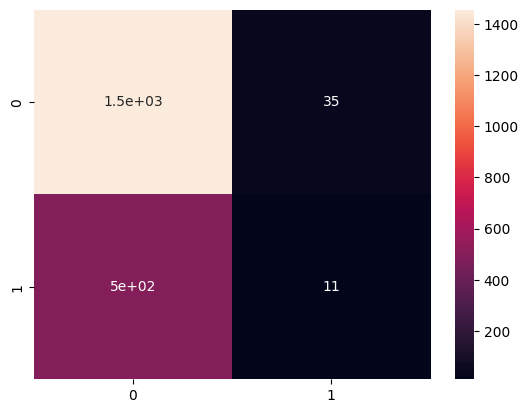

In [165]:
clf = RandomForestClassifier(random_state = 42,n_estimators=2000,n_jobs=-1) 
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

### XGBoost

In [166]:
xgbclf = xgb.XGBClassifier()

In [167]:
prams={
'n_estimators':[100,200,500,1000,2000],
'max_depth':[3,5,10]
}
random_cfl1=RandomizedSearchCV(xgbclf,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000]},
                   verbose=10)

In [168]:
random_cfl1.best_params_

{'n_estimators': 100, 'max_depth': 3}

ACCURACY: 0.7115673510265398
F-1 SCORE: 0.11384615384615385
F-0.5 SCORE WEIGHTED: 0.6232669345794508
F-0.5 SCORE MACRO: 0.4742296588797797
F-0.5 SCORE MICRO: 0.7115673510265398
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1490
           1       0.26      0.07      0.11       507

    accuracy                           0.71      1997
   macro avg       0.50      0.50      0.47      1997
weighted avg       0.62      0.71      0.65      1997

CONFUSION MATRIX:


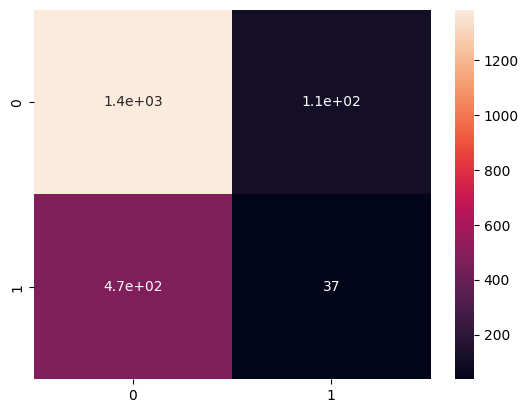

In [169]:
xclf = xgb.XGBClassifier(n_estimators=500,max_depth=3)
xclf.fit(X_train, y_train)
y_pred = xclf.predict(X_test)
evaluate(y_test,y_pred)

### Naive Bayes

ACCURACY: 0.543314972458688
F-1 SCORE: 0.3101361573373676
F-0.5 SCORE WEIGHTED: 0.5970520382362043
F-0.5 SCORE MACRO: 0.48986142204444605
F-0.5 SCORE MICRO: 0.543314972458688
              precision    recall  f1-score   support

           0       0.74      0.59      0.66      1490
           1       0.25      0.40      0.31       507

    accuracy                           0.54      1997
   macro avg       0.50      0.50      0.48      1997
weighted avg       0.62      0.54      0.57      1997

CONFUSION MATRIX:


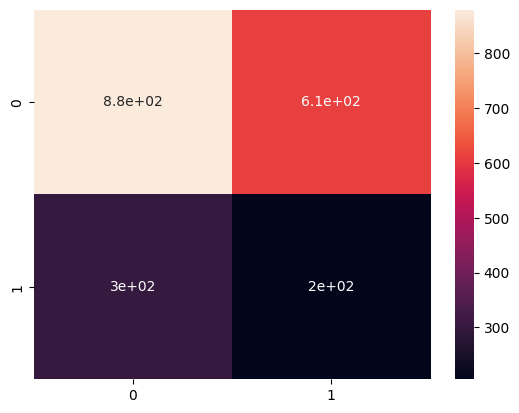

In [170]:
clf = GaussianNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

In [171]:
params = {'alpha':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}

In [172]:
clf = MultinomialNB()

In [ ]:
nb_clf.best_params_

In [ ]:
clf = MultinomialNB(alpha=1e-05)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

### SVM

In [174]:
params= {'alpha':[10 ** x for x in range(-5, 3)]}

In [175]:
clf = SGDClassifier(penalty='l2', loss='hinge', random_state=42)
svm_clf = GridSearchCV(clf,param_grid=params,verbose=10,n_jobs=-1)
svm_clf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                                   100]},
             verbose=10)

In [ ]:
svm_clf.best_params_

In [ ]:
clf = SGDClassifier(alpha=1e-05,penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

### Logistic Regression

c:\Users\ProBook\Desktop\Work\Desights\Discord Community\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ProBook\Desktop\Work\Desights\Discord Community\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ProBook\Desktop\Work\Desights\Discord Community\env\Lib\site-packages\sklearn\metrics

ACCURACY: 0.7461191787681523
F-1 SCORE: 0.0
F-0.5 SCORE WEIGHTED: 0.586472661091236
F-0.5 SCORE MACRO: 0.3930154040936907
F-0.5 SCORE MICRO: 0.7461191787681523
              precision    recall  f1-score   support

           0       0.75      1.00      0.85      1490
           1       0.00      0.00      0.00       507

    accuracy                           0.75      1997
   macro avg       0.37      0.50      0.43      1997
weighted avg       0.56      0.75      0.64      1997

CONFUSION MATRIX:


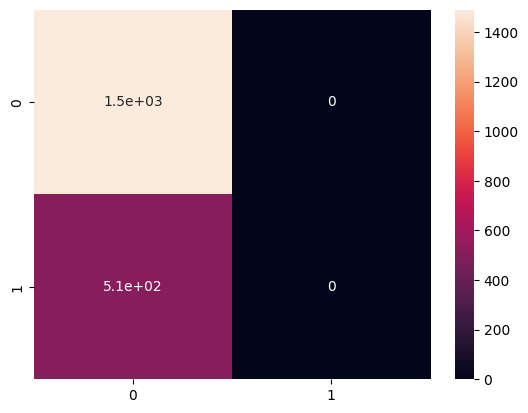

In [176]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

### Decision Treee

In [177]:
clf = DecisionTreeClassifier(random_state=0)

In [178]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}

In [179]:
dt = GridSearchCV(estimator=clf, param_grid=params, n_jobs=-1, verbose=1)

In [180]:
dt.fit(X_train,y_train)
dt.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'max_depth': 2, 'min_samples_leaf': 100}

In [181]:
dt_clf = DecisionTreeClassifier(max_depth=20,min_samples_leaf=5,random_state=0)
dt_clf.fit(X_train,y_train)
     

DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, random_state=0)

ACCURACY: 0.6770155232849274
F-1 SCORE: 0.1456953642384106
F-0.5 SCORE WEIGHTED: 0.6167600387107464
F-0.5 SCORE MACRO: 0.47382774784100706
F-0.5 SCORE MICRO: 0.6770155232849274
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1490
           1       0.22      0.11      0.15       507

    accuracy                           0.68      1997
   macro avg       0.48      0.49      0.47      1997
weighted avg       0.61      0.68      0.63      1997

CONFUSION MATRIX:


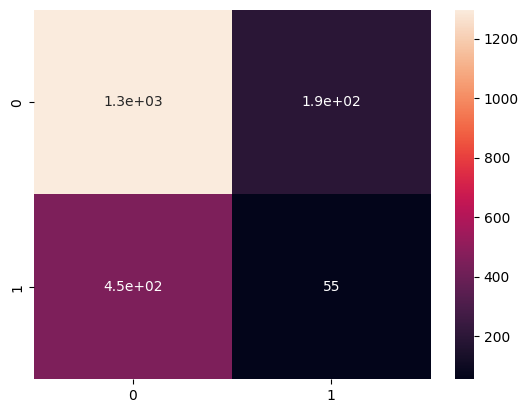

In [182]:
y_pred = dt_clf.predict(X_test)
evaluate(y_test,y_pred)
    

Potential Sources:

User-related issues: These may include user errors, misunderstandings, or lack of knowledge about certain features or functionalities.

System-related issues: These are technical problems or bugs within the Ocean Protocol platform or related software components.

External factors: These could be issues caused by third-party services, network connectivity problems, or other external factors beyond the control of users or the platform.